# Claims Analysis

In [44]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [239]:
import operator
import math
from gb.hypergraph.hypergraph import HyperGraph
import gb.hypergraph.symbol as sym
import gb.hypergraph.edge as ed
import gb.nlp.parser as par
import gb.tools.json as json_tools
from gb.synonyms.meronomy import Meronomy
from gb.metrics.hyper_similarity import HyperSimilarity

import numpy as np
import matplotlib.pyplot as plt

### Constants

In [3]:
MAX_PROB = -12

### HyperGraph

In [134]:
hg = HyperGraph({'backend': 'leveldb', 'hg': '../reddit-worldnews-01012013-01082017.hg'})

### Start parser

In [4]:
parser = par.Parser()

### Aux Functions

In [137]:
def rel_contains(full_edge, term):
    if sym.is_edge(full_edge) and len(full_edge) > 2 and sym.is_edge(full_edge[2]):
        rel = full_edge[0]
        if sym.is_edge(rel):
            return term in rel
        else:
            return rel == term
    return False


def edge2str(edge):
    s = ed.edge2str(edge, namespaces=False)
    if sym.is_edge(edge):
        return s

    if s[0] == '+':
        s = s[1:]

    if len(s) == 0:
        return None

    if not s[0].isalnum():
        return None

    word = parser.make_word(s)
    if word.prob < MAX_PROB:
        return s

    return None


def edge2syn(edge):
    atom = edge2str(edge)
    if atom:
        syn_id = mer.syn_id(atom)
        if syn_id:
            return syn_id
    return None

### Meronomy and Say Edges

In [185]:
mer = Meronomy(parser)

edge_data = json_tools.read('../all-reddit-worldnews-01012013-01082017.json')

say_edges = []
for it in edge_data:
    edge_ns = ed.str2edge(it['edge'])
    mer.add_edge(edge_ns)
    edge = ed.without_namespaces(edge_ns)
    
    # (says x ...)
    if rel_contains(edge, 'says'):
        say_edges.append(edge)
        
mer.generate()

### Sayers, sayers + claims & sorted sayers

In [186]:
sayers = {}
sayers_and_claims = {}
for edge in say_edges:
    sayer = edge2syn(edge[1])
    if sayer not in sayers_and_claims:
        sayers[sayer] = 0
        sayers_and_claims[sayer] = []
    sayers[sayer] += 1
    sayers_and_claims[sayer].append(edge[2])
        
sorted_sayers = sorted(sayers.items(), key=operator.itemgetter(1), reverse=True)

### Concepts by sayer

In [187]:
concepts_by_sayer = {}


def add_concepts(targ, src):
    for key in src:
        if key in targ:
            targ[key] += src[key]
        else:
            targ[key] = src[key]


def concepts_in_claim(claim, concept_map=None, deep=True):
    if not concept_map:
        concept_map = {}
    syn_id = edge2syn(claim)
    if syn_id:
        if syn_id not in concept_map:
            concept_map[syn_id] = 0
        concept_map[syn_id] += 1
        
        if deep:
            if sym.is_edge(claim):
                for item in claim:
                    concepts_in_claim(item, concept_map)
    return concept_map


def get_concepts_by_sayer(sayer, that_include=None):
    concept_map = {}
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        if not that_include:
            add_concepts(concept_map, claim_concepts)
        elif that_include in claim_concepts.keys():
            del claim_concepts[that_include]
            add_concepts(concept_map, claim_concepts)
    return concept_map


for sayer in sayers_and_claims:
    concepts_by_sayer[sayer] = get_concepts_by_sayer(sayer)

### Who talks about who graph

In [188]:
who_who = {}

actors = [sayer for sayer in sayers if sayer and len(sayers_and_claims[sayer]) > 1]
active_actors = set()

def add_edge(orig, targ):
    if orig and targ:
        if orig not in who_who:
            who_who[orig] = {}
        if targ not in who_who[orig]:
            who_who[orig][targ] = 0
        who_who[orig][targ] += 1
        if orig != targ:
            active_actors.add(orig)
            active_actors.add(targ)

for sayer in actors:
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        for concept in claim_concepts:
            if concept in actors:
                add_edge(sayer, concept)
            
file = open('../who_who.gml', 'w')
file.write('graph\n[\n')
for actor in active_actors:
    # print(actor)
    file.write('node\n[\nid %s\nlabel "%s"\n]\n' % (str(actor), mer.synonym_label(actor, short=True)))
for orig in who_who:
    for targ in who_who[orig]:
        w = who_who[orig][targ]
        file.write('edge\n[\nsource %s\ntarget %s\nweight %s\n]\n' % (str(orig), str(targ), str(w)))
file.write(']\n')
file.close()

### Concept-actor graph

In [207]:
concept_actor = {}

def add_edge(orig, targ):
    if orig and targ:
        if orig not in concept_actor:
            concept_actor[orig] = {}
        if targ not in concept_actor[orig]:
            concept_actor[orig][targ] = 0
        concept_actor[orig][targ] += 1

def actors_for_concept(concept):
    return concept_actor[concept].keys()
        
for sayer in actors:
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        for concept in claim_concepts:
            add_edge(concept, sayer)

concept_metrics = {}
            
for concept in concept_actor:
    weights = [concept_actor[concept][actor] for actor in concept_actor[concept]]
    total = sum(weights)
    h_weights = [float(i) / float(total) for i in weights]
    h_weights = [i * i for i in h_weights]
    h = 1. / sum(h_weights)
    concept_metrics[concept] = {'total': total, 'h': h}

### Dispersion of Concepts amongst Actors

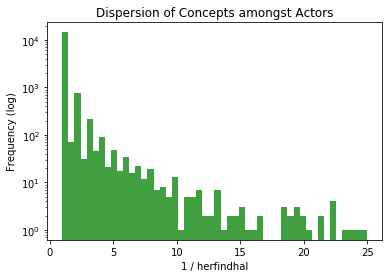

In [190]:
x = [concept_metrics[concept]['h'] for concept in concept_metrics]
x = [i for i in x if i < 25]

# the histogram of the data
n, bins, patches = plt.hist(x, 50, log=True, facecolor='green', alpha=0.75)

plt.xlabel('1 / herfindhal')
plt.ylabel('Frequency (log)')
plt.title('Dispersion of Concepts amongst Actors')

plt.show()

### Show Top Actors

In [192]:
for t in sorted_sayers[:20]:
    syn_id = t[0]
    if syn_id:
        print('%s %s %s %s' % (syn_id, mer.synonym_label(syn_id), t[1], len(concepts_by_sayer[syn_id])))

900755 {russia} 196 979
900105 {iran} 110 455
233 {korea, (+ north korea)} 106 433
900613 {putin} 92 446
899993 {turkey} 70 355
900731 {ukraine} 67 258
845 {francis, pope, (+ pope francis)} 59 301
906330 {erdogan} 48 199
1354 {arabia, saudi, (+ saudi arabia)} 46 239
899976 {syria} 44 177
901879 {pakistan} 42 171
900578 {france} 41 204
914672 {(+ south korea)} 38 191
801 {cameron, david, (+ david cameron)} 34 154
900097 {japan} 32 180
455 {kremlin, (+the kremlin)} 31 143
39 {(+ angela merkel), angela, merkel} 31 170
900473 {trump} 30 126
899969 {eu} 27 140


### Concepts by actor

In [221]:
concepts = concepts_by_sayer[845]

sorted_concepts = sorted(concepts.items(), key=operator.itemgetter(1), reverse=True)
for t in sorted_concepts[:20]:
    syn_id = t[0]
    if syn_id:
        print('%s %s %s' % (mer.synonym_label(syn_id, short=True), t[1], concept_metrics[syn_id]['h']))

very grave sin 6 1.0
or terrorism fundamentalism 6 1.0
's amount world many conflicts 5 1.0
is it wrong to_equate islam with violence 5 1.0
pope francis 4 2.9999999999999996
catholic church 3 4.5
the vatican 3 4.499999999999999
to visit nation 3 1.0
their lands.pope 3 1.0
as seeks trump to_advance its construction 3 1.0
on sunday 3 6.4
as do they their mobile phones 3 1.0
17-month slide 3 1.0
on war marriage 3 1.0
by militants name unprecedented violence condemned islamist militants 3 1.0
convicted pedophiles 2 1.0
assisted suicide 2 1.0
the church 2 1.0
of state israel 2 1.0
- migrant walls anti 2 1.0


### Concepts by actor and $1/herfindhal$

In [222]:
ego = 845
concepts = concepts_by_sayer[ego]

concepts_by_h = {}
for concept in concepts:
    h = int(round(concept_metrics[concept]['h']))
    if h not in concepts_by_h:
        concepts_by_h[h] = []
    concepts_by_h[h].append(concept)

for syn_id in concepts_by_h[2][:20]:
    actors = [mer.synonym_label(actor, short=True) for actor in actors_for_concept(syn_id) if actor != ego]
    actor_str = ', '.join(actors)
    print('[%s] %s %s {%s}' % (syn_id, mer.synonym_label(syn_id, short=True), concept_metrics[syn_id]['h'], actor_str))

[1389165] pedophiles about 8,000 1.0 {}
[18413] convicted pedophiles 1.0 {}
[1184733] about 8,000 1.0 {}
[1648] more 8,000 than 1.0 {}
[420659] after even divorce 1.0 {}
[1276297] unprepared remarks 1.0 {}
[929403] unprepared 1.0 {}
[1658] assisted suicide 1.0 {}
[1397377] journalism based_on fear mongering 1.0 {}
[1397378] based_on fear mongering 1.0 {}
[1397379] fear mongering 1.0 {}
[266814] 's he not communist 1.0 {}
[423023] for stop world 1.0 {}
[905710] the church 1.0 {}
[1400166] show europe attacks world at war 1.0 {}
[423489] europe attacks 1.0 {}
[423888] questions gender theory 1.0 {}
[1403051] is attack on the of state israel anti semitism 1.0 {}
[1403052] attack on the of state israel 1.0 {}
[1403053] on the of state israel 1.0 {}


### Who talks about what - Ego Graph

In [216]:
ego = 845
who_what = {}

concepts = concepts_by_sayer[ego]

nodes = set()

def add_edge(orig, targ, weight):
    if orig and targ:
        if orig not in who_what:
            who_what[orig] = {}
        who_what[orig][targ] = weight
        nodes.add(orig)
        nodes.add(targ)

for concept in concepts:
    if len(concept_actor[concept]) > 1:
        for actor in concept_actor[concept]:
            add_edge(actor, concept, concept_actor[concept][actor])
        
file = open('../who_what.gml', 'w')
file.write('graph\n[\n')
for node in nodes:
    file.write('node\n[\nid %s\nlabel "%s"\n]\n' % (str(node), mer.synonym_label(node, short=True)))
for orig in who_what:
    for targ in who_what[orig]:
        w = who_what[orig][targ]
        file.write('edge\n[\nsource %s\ntarget %s\nweight %s\n]\n' % (str(orig), str(targ), str(w)))
file.write(']\n')
file.close()

In [231]:
ego = 900578

concepts = concepts_by_sayer[ego]

file = open('../france.csv', 'w')
file.write('concept,herfindahl,total,ego_total,actors\n')
for concept in concepts:
    file.write('%s,%s,%s,%s,' % (mer.synonym_label(concept, short=True),
                                 concept_metrics[concept]['h'],
                                 concept_metrics[concept]['total'],
                                 concept_actor[concept][ego]))
    actor_str = '|'.join([mer.synonym_label(actor, short=True) for actor in concept_actor[concept] if actor != ego])
    file.write('%s\n' % actor_str)
file.write('\n')
file.close()

In [157]:
# common concepts

actor1 = 845
actor2 = 455

concepts1 = set(concepts_by_sayer[actor1].keys())
concepts2 = set(concepts_by_sayer[actor2].keys())

common = concepts1.intersection(concepts2)
for concept in common:
    print('*** %s %s %s' % (mer.synonym_label(concept, short=True),
                            concept_actor[concept][actor1],
                            concept_actor[concept][actor2]))
    for claim in sayers_and_claims[actor1]:
        claim_concepts = concepts_in_claim(claim)
        if concept in claim_concepts:
            print('###')
            for concept_ in claim_concepts:
                if concept != concept_:
                    # pass
                    print('> %s %s' % (actor1, mer.synonym_label(concept_, short=True)))
    for claim in sayers_and_claims[actor2]:
        claim_concepts = concepts_in_claim(claim)
        if concept in claim_concepts:
            print('###')
            for concept_ in claim_concepts:
                if concept != concept_:
                    # pass
                    print('> %s %s' % (actor2, mer.synonym_label(concept_, short=True)))

*** trump 2 2
###
> 845 have indigenous people over rights their lands.pope does_n't cite dakota pipeline by name as seeks trump to_advance its construction
> 845 indigenous people
> 845 indigenous
> 845 their lands.pope
> 845 does_n't cite dakota pipeline by name as seeks trump to_advance its construction
> 845 does_n't
> 845 dakota pipeline
> 845 in field south dakota
> 845 gas pipeline
> 845 name by name
> 845 as seeks trump to_advance its construction
> 845 seeks
> 845 to_advance
###
> 845 will_try and he to_find common ground with donald trump when_meet they not preach
> 845 will_try
> 845 and he
> 845 to_find common ground with donald trump when_meet they
> 845 to_find
> 845 common ground
> 845 with donald trump
> 845 donald trump
> 845 when_meet they
> 845 when_meet
> 845 not preach
> 845 preach
###
> 455 trump agree putin to_work_closely
> 455 putin
> 455 to_work_closely
###
> 455 agreed putin meeting trump for 7 july in hamburg agencies
> 455 putin meeting trump
> 455 putin
> 

In [ ]:
concepts = get_concepts_by_sayer(2, that_include=19)
for concept in concepts:
    print('%s %s' % (mer.synonym_label(concept), concepts[concept]))

In [242]:
hs = HyperSimilarity(hg)

c1 = 1001446   # global economy
c2 = 901310    # the internet
c3 = 268073    # financial crisis
c4 = 904111    # twitter

hs.synonym_similarity(mer, c1, c2)

0.0018332747152404478